In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from pprint import pprint
import pysteps
from pysteps import io, nowcasts, rcparams
from pysteps.motion.lucaskanade import dense_lucaskanade # 这是lucaskanade方法
from pysteps.postprocessing.ensemblestats import excprob
from pysteps.utils import conversion, dimension, transformation
from pysteps.visualization import plot_precip_field
# Set nowcast parameters
n_ens_members = 20
n_leadtimes = 6
seed = 24

Pysteps configuration file found at: C:\Users\Kai‘s Laptop\pysteps\pystepsrc



In [2]:
import cartopy

In [3]:
date = datetime.strptime("202105220045", "%Y%m%d%H%M")

data_source = "westaf"  # 这个是我自己希望导入的数据


In [4]:
pysteps.rcparams['data_sources']

{'bom': {'root_path': 'C:\\Users\\Kai‘s Laptop\\pysteps_data\\radar\\bom',
  'path_fmt': 'prcp-cscn/2/%Y/%m/%d',
  'fn_pattern': '2_%Y%m%d_%H%M00.prcp-cscn',
  'fn_ext': 'nc',
  'importer': 'bom_rf3',
  'timestep': 6,
  'importer_kwargs': {'gzipped': True}},
 'fmi': {'root_path': 'C:\\Users\\Kai‘s Laptop\\pysteps_data\\radar\\fmi',
  'path_fmt': '%Y%m%d',
  'fn_pattern': '%Y%m%d%H%M_fmi.radar.composite.lowest_FIN_SUOMI1',
  'fn_ext': 'pgm.gz',
  'importer': 'fmi_pgm',
  'timestep': 5,
  'importer_kwargs': {'gzipped': True}},
 'mch': {'root_path': 'C:\\Users\\Kai‘s Laptop\\pysteps_data\\radar\\mch',
  'path_fmt': '%Y%m%d',
  'fn_pattern': 'AQC%y%j%H%M?_00005.801',
  'fn_ext': 'gif',
  'importer': 'mch_gif',
  'timestep': 5,
  'importer_kwargs': {'product': 'AQC', 'unit': 'mm', 'accutime': 5}},
 'mrms': {'root_path': 'C:\\Users\\Kai‘s Laptop\\pysteps_data\\mrms',
  'path_fmt': '%Y/%m/%d',
  'fn_pattern': 'PrecipRate_00.00_%Y%m%d-%H%M%S',
  'fn_ext': 'grib2',
  'importer': 'mrms_grib',
  

In [5]:
# # Load data source config
root_path = rcparams.data_sources[data_source]["root_path"]
print(root_path)
path_fmt = rcparams.data_sources[data_source]["path_fmt"]
print(path_fmt)
fn_pattern = rcparams.data_sources[data_source]["fn_pattern"]
print(fn_pattern)
fn_ext = rcparams.data_sources[data_source]["fn_ext"]
importer_name = rcparams.data_sources[data_source]["importer"]
print(importer_name)
importer_kwargs = rcparams.data_sources[data_source]["importer_kwargs"]
print(importer_kwargs)
timestep = rcparams.data_sources[data_source]["timestep"]

C:\westaf\20210522old
%Y%m%d
CRR_rainfall_%Y%m%d_%H%M_regridded_nearest
mch_gif
{'product': 'AQC', 'unit': 'mm', 'accutime': 5}


In [6]:
# Find the radar files in the archive
fns = io.find_by_date(
    date, root_path, path_fmt, fn_pattern, fn_ext, timestep, num_prev_files=0, num_next_files=3
)
# print(date)


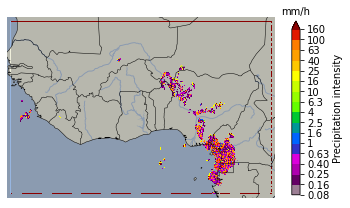

{'accutime': 5,
 'cartesian_unit': 'm',
 'institution': 'MeteoSwiss',
 'product': 'AQC',
 'projection': '+proj=somerc  +lon_0=8.43958333333333 +lat_0=5.9524055555556 '
               '+k_0=1 +x_0=600000 +y_0=200000 +ellps=bessel '
               '+towgs84=674.374,15.056,405.346,0,0,0,0 +units=m +no_defs',
 'threshold': -10.0,
 'timestamps': array([datetime.datetime(2021, 5, 22, 0, 45),
       datetime.datetime(2021, 5, 22, 1, 0),
       datetime.datetime(2021, 5, 22, 1, 15),
       datetime.datetime(2021, 5, 22, 1, 30)], dtype=object),
 'transform': 'dB',
 'unit': 'mm/h',
 'x1': -2200000.0,
 'x2': 1500000.0,
 'xpixelsize': 1000.0,
 'y1': -700000.0,
 'y2': 1800000.0,
 'yorigin': 'upper',
 'ypixelsize': 1000.0,
 'zerovalue': -15.0,
 'zr_a': 316.0,
 'zr_b': 1.5}


In [7]:
# Read the data from the archive
importer = io.get_method(importer_name, "importer")
R, _, metadata = io.read_timeseries(fns, importer, **importer_kwargs)

# Convert to rain rate
R, metadata = conversion.to_rainrate(R, metadata)

# Upscale data to 2 km to limit memory usage
R, metadata = dimension.aggregate_fields_space(R, metadata, 1000)

# Plot the rainfall field
plot_precip_field(R[-1, :, :], geodata=metadata)
plt.show()

# Log-transform the data to unit of dBR, set the threshold to 0.1 mm/h,
# set the fill value to -15 dBR
R, metadata = transformation.dB_transform(R, metadata, threshold=0.1, zerovalue=-15.0)

# Set missing values with the fill value
R[~np.isfinite(R)] = -15.0

# Nicely print the metadata
pprint(metadata)

Computing S-PROG nowcast:
-------------------------

Inputs:
-------
input dimensions: 1259x2385

Methods:
--------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
conditional statistics: no
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters:
-----------
number of time steps:     6
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
precip. intensity threshold: -10
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------
| Level |     Lag-1     |     Lag-2     |
-----------------------------------------
| 1     | 0.999367      | 0.997115      |
-----------------------------------------
| 2     | 0.995669      | 0.985648      |
-----------------------------------------
| 3     | 0.940079      | 0.839484      |
--------------

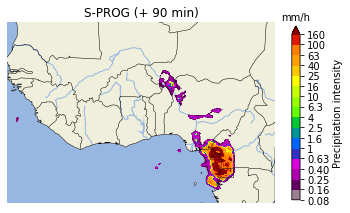

In [10]:
# Estimate the motion field
V = dense_lucaskanade(R)

# The S-PROG nowcast
nowcast_method = nowcasts.get_method("sprog")
R_f = nowcast_method(
    R[-3:, :, :],
    V,
    n_leadtimes,
    n_cascade_levels=6,
    R_thr=-10.0,
)

# Back-transform to rain rate
R_f = transformation.dB_transform(R_f, threshold=-10.0, inverse=True)[0]

# Plot the S-PROG forecast
plot_precip_field(
    R_f[-1, :, :],
    geodata=metadata,
    title="S-PROG (+ %i min)" % (n_leadtimes * timestep),
)
plt.show()

In [9]:
# The STEPS nowcast
nowcast_method = nowcasts.get_method("steps")
R_f = nowcast_method(
    R[-3:, :, :],
    V,
    n_leadtimes,
    n_ens_members,
    n_cascade_levels=6,
    R_thr=-10.0,
    kmperpixel=2.0,
    timestep=timestep,
    noise_method="nonparametric",
    vel_pert_method="bps",
    mask_method="incremental",
    seed=seed,
)

# Back-transform to rain rates
R_f = transformation.dB_transform(R_f, threshold=-10.0, inverse=True)[0]


# Plot the ensemble mean
R_f_mean = np.mean(R_f[:, -1, :, :], axis=0)
plot_precip_field(
    R_f_mean,
    geodata=metadata,
    title="Ensemble mean (+ %i min)" % (n_leadtimes * timestep),
)
plt.show()

Computing STEPS nowcast:
------------------------

Inputs:
-------
input dimensions: 1259x2385
km/pixel:         2
time step:        15 minutes

Methods:
--------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters:
-----------
number of time steps:     6
ensemble size:            20
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: -10
************************************************
* Correlation coefficients for cascade levels: *
************************************************
----------------------------------

MemoryError: 

IndexError: too many indices for array

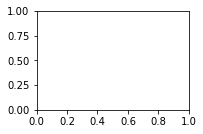

In [9]:
# Plot some of the realizations
fig = plt.figure()
for i in range(4):
    ax = fig.add_subplot(221 + i)
    ax = plot_precip_field(
        R_f[i, -1, :, :], geodata=metadata, colorbar=False, axis="off"
    )
    ax.set_title("Member %02d" % i)
plt.tight_layout()
plt.show()

In [10]:
# Compute exceedence probabilities for a 0.5 mm/h threshold
P = excprob(R_f[:, -1, :, :], 0.5)

# Plot the field of probabilities
plot_precip_field(
    P,
    geodata=metadata,
    ptype="prob",
    units="mm/h",
    probthr=0.5,
    title="Exceedence probability (+ %i min)" % (n_leadtimes * timestep),
)
plt.show()

# sphinx_gallery_thumbnail_number = 5

IndexError: too many indices for array